In [29]:
""" Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series.
"""
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random
# %matplotlib notebook


In [15]:
import csv

In [16]:
np.random.seed(1234)

# Global hyper-parameters
sequence_length = 10
epochs = 5
batch_size = 50


In [19]:
def readCSV():
    f = open('../data/cep/ceptrain.csv')
    states = []
    try:
        reader = csv.reader(f)
        for row in reader:
            states.append(row)
    finally:
        f.close()
    train_data = np.array(states)
    print (train_data.shape)
    return train_data

In [20]:
readCSV()

(204205, 1)


array([['0.0'],
       ['0.0'],
       ['0.0'],
       ..., 
       ['0.0'],
       ['0.0'],
       ['4.0']], 
      dtype='<U5')

In [21]:
def z_norm(result):
    result = np.float64(result)
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean




In [22]:
def get_split_prep_data(train_start, train_end,
                        test_start, test_end):
    #data = gen_wave()
    data = readCSV()
    print("Length of Data", len(data))

    # train data
    print("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)

    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)
    #print result
    train = result[train_start:train_end, :]
    #np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    #X_train, y_train = dropin(X_train, y_train)

    print("Shape X_train", np.shape(X_train))
    print("Shape y_train", np.shape(y_train))

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_test", np.shape(X_test))
    print("Shape y_test", np.shape(y_test))


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [34]:
def get_anomaly_data():
    f = open('../data/anomaly_pausetime.csv')
    states = []
    try:
        reader = csv.reader(f)
        for row in reader:
            states.append(row)
    finally:
        f.close()
    anomaly_data = np.array(states)
    print (anomaly_data.shape)
    return anomaly_data

In [35]:
def get_training_data():
    f = open('../data/cep/ceptrain.csv')
    states = []
    try:
        reader = csv.reader(f)
        for row in reader:
            states.append(row)
    finally:
        f.close()
    train_data = np.array(states)
    print (train_data.shape)
    return train_data

In [44]:
def train_anomaly_data():
    train_data = get_training_data()
    print("Length of Training data", len(train_data))

    # train data
    print("Creating train data...")

    result = []
    for index in range(0, train_data.size- sequence_length):
        result.append(train_data[index: index + sequence_length])
    result = np.array(result)

#     result, result_mean = z_norm(result)

#     print ("Mean of train data : ", result_mean)
#     print ("Train data shape  : ", result.shape)
    #print result
    train = result[0:train_data.size, :]
    #np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    #X_train, y_train = dropin(X_train, y_train)

    print("Shape X_train", np.shape(X_train))
    print("Shape y_train", np.shape(y_train))

    # test data
    print ("Creating test data...")
    anomaly_data = get_anomaly_data()
    print("Length of anomaly data", len(anomaly_data))
    
    result = []
    for index in range(0, anomaly_data.size - sequence_length):
        result.append(anomaly_data[index: index + sequence_length])
    result = np.array(result)
#     result, result_mean = z_norm(result)

#     print ("Mean of test data : ", result_mean)
#     print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_test", np.shape(X_test))
    print("Shape y_test", np.shape(y_test))


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test
    

In [47]:
# train_anomaly_data()

In [46]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 5, 'hidden2': 10, 'hidden3': 5, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

In [48]:
def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print ('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
#         X_train, y_train, X_test, y_test = get_split_prep_data(0, 200000,200001, 204206)
        X_train, y_train, X_test, y_test = train_anomaly_data()

    else:
        X_train, y_train, X_test, y_test = data

    print ('\nData Loaded. Compiling...\n')

    
    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    print( 'Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted


In [49]:
def showPlot(Predicted, y_test):
    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        y_te = np.array(y_test,dtype=float)
        pred = np.array(predicted,dtype=float)

        mse = ((y_te - pred) ** 2)
        plt.plot(mse, 'r')
        plt.show()
        print("success")
        plt.savefig( 'myfig.png' )
    except Exception as e:
        print("plotting exception")
        print (str(e))

In [50]:
model,y_test,predicted=run_network()

Loading data... 
(204205, 1)
Length of Training data 204205
Creating train data...
Shape X_train (204195, 9, 1)
Shape y_train (204195, 1)
Creating test data...
(224, 1)
Length of anomaly data 224
Shape X_test (214, 9, 1)
Shape y_test (214, 1)

Data Loaded. Compiling...

Compilation Time :  0.028210878372192383
Training...
Train on 193985 samples, validate on 10210 samples
Epoch 1/5
193985/193985 [==============================] - 235s - loss: 8.1399 - val_loss: 14.9346
Epoch 2/5
193985/193985 [==============================] - 227s - loss: 8.1401 - val_loss: 14.9376
Epoch 3/5
193985/193985 [==============================] - 208s - loss: 8.1404 - val_loss: 14.9359
Epoch 4/5
193985/193985 [==============================] - 241s - loss: 8.1401 - val_loss: 14.9354
Epoch 5/5
193985/193985 [==============================] - 285s - loss: 8.1400 - val_loss: 14.9377
Predicting...
Reshaping predicted
Training duration (s) :  1364.2625346183777


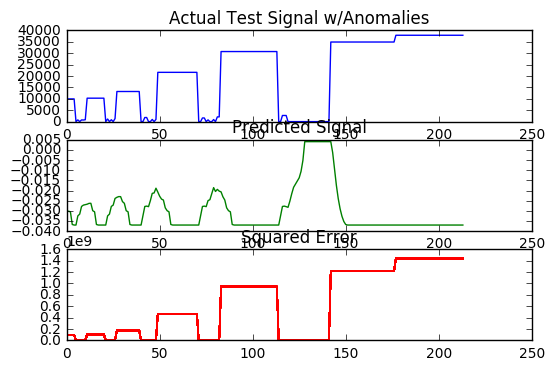

success


In [51]:
showPlot(predicted,y_test)